## Web Scraping: Extracting Data from the Web

## Some Import

In [219]:
%matplotlib inline 
from selenium import webdriver
import time,re,json,numpy as np
import pandas as pd
from collections import defaultdict,Counter
import matplotlib.pyplot as plt

## Initial Setup and Launch the browser to open the URL

In [1]:
url = "http://www.imdb.com/list/ls061683439/"
with open('./img/filmfare.json',encoding="utf-8") as f:
    datatbl = json.load(f)
driver = webdriver.Chrome(datatbl['data']['chromedriver'])
driver.get(url)

NameError: name 'json' is not defined

## Getting Data

### Function to extract the data from Web using Selenium

In [221]:
def ExtractText(Xpath):
    textlist=[]
    if(Xpath=='Movies_Director_Xpath'):
        for item in range(1,123,2):
            textlist.append(driver.find_element_by_xpath(datatbl['data'][Xpath]+'[%d]'%item).text)
    else:
        [textlist.append(item.text) for item in driver.find_elements_by_xpath(datatbl['data'][Xpath])]
    return textlist

### Let's extract all the required data like Ratings,Votes,Genre, Year of Release for the Best Movies

In [222]:
#Extracting Data from Web
Movies_Votes,Movies_Name,Movies_Ratings,Movies_RunTime=[[] for i in range(4)]
datarepo = [[]]*5
Xpath_list = ['Movies_Name_Xpath','Movies_Rate_Xpath','Movies_Runtime_Xpath','Movies_Votes_Xpath',
              'Movies_Director_Xpath']

for i in range(5):
    if(i==3):
        driver.find_element_by_xpath(datatbl['data']['listview']).click()
    if(i==4):
        driver.find_element_by_xpath(datatbl['data']['detailview']).click()
    datarepo[i] = ExtractText(Xpath_list[i])

driver.quit()

# How does data looks now?
## Is this Data is in the correct format to perform data manipulation?

## The individual movie related data is stored in a Python List, it's hard to corelated the data attributes with the respective Movies 

In [223]:
# Movie Name List & Ratings
print(datarepo[0][:5])
print("")
print(datarepo[3][:5])

['Bajirao Mastani', 'Queen', 'Bhaag Milkha Bhaag', 'Barfi!', 'Zindagi Na Milegi Dobara']

['17,362', '39,518', '39,731', '52,308', '41,731']


# Store Data in a  Python Dictionary

## The data is stored in a python dictionary which is more structured way to store the data here and all the movie attributes are now linked with the respective movie

In [224]:
# Result in a Python Dictionary
Years=range(2015,1954,-1)
result = defaultdict(dict)
for i in range(0,len(datarepo[0])):
    result[i]['Movie Name']= datarepo[0][i]
    result[i]['Year']= Years[i]
    result[i]['Rating']= datarepo[1][i]
    result[i]['Votes']= datarepo[3][i]
    result[i]['RunTime']= datarepo[2][i]
    result[i]['Genre']= datatbl['data']['Genre'][i]
    result[i]['Director']= datarepo[4][i]


# Let's see now how the data in dictionary looks like?

In [225]:
import pprint as pp
pp = pprint.PrettyPrinter(depth=10)
pp.pprint(result[0])

{'Director': 'Director: Sanjay Leela Bhansali',
 'Genre': 'Drama',
 'Movie Name': 'Bajirao Mastani',
 'Rating': '7.2',
 'RunTime': 'A historical account of the romance between the Maratha general, '
            'Baji Rao I and Mastani, a Muslim princess. (158 mins.)',
 'Votes': '17,362',
 'Year': 2015}


In [226]:
print(json.dumps((result[0]),indent=4))

{
    "Director": "Director: Sanjay Leela Bhansali",
    "Votes": "17,362",
    "RunTime": "A historical account of the romance between the Maratha general, Baji Rao I and Mastani, a Muslim princess. (158 mins.)",
    "Year": 2015,
    "Genre": "Drama",
    "Movie Name": "Bajirao Mastani",
    "Rating": "7.2"
}


## Oh! Something is wrong with the data, It's not in right shape to perform analysis on this data set

## Let's clean the data

* Replace the comma(,) in Vote Value and change the data type to int
* Change the Data type for Rating and RunTime

In [227]:
for key,values in result.items():
    values['Votes'] = int(values['Votes'].replace(",",""))
    values['Rating']= float(values['Rating'])
    values['Director']= values['Director'].replace('Director: ','')
    try:
        values['RunTime'] = int(re.findall(r'\d+',values['RunTime'])[-1])
    except TypeError:
        values['RunTime'] = np.NaN
    except IndexError:
        values['RunTime'] = np.NaN

## Now let's look at the data and see how it looks like

In [228]:
print(json.dumps((result[0]),indent=4))

{
    "Director": "Sanjay Leela Bhansali",
    "Votes": 17362,
    "RunTime": 158,
    "Year": 2015,
    "Genre": "Drama",
    "Movie Name": "Bajirao Mastani",
    "Rating": 7.2
}


## Data in Pandas Dataframe

<img src="./img/Dataframe.png">

## Data is consumed in a Pandas Dataframe, Which is more convenient way to perform data analysis,manipulation or aggregation

In [229]:
# create dataframe
df = pd.DataFrame.from_dict(result,orient='index')
df = df[['Year', 'Movie Name', 'Rating', 'Votes','Genre','RunTime','Director']]
df.index = np.arange(1, 62)
df.head(10)

,Year,Movie Name,Rating,Votes,Genre,RunTime,Director
1,2015,Bajirao Mastani,7.2,17362,Drama,158,Sanjay Leela Bhansali
2,2014,Queen,8.4,39518,Drama,146,Vikas Bahl
3,2013,Bhaag Milkha Bhaag,8.3,39731,Drama,186,Rakeysh Omprakash Mehra
4,2012,Barfi!,8.2,52308,Family,151,Anurag Basu
5,2011,Zindagi Na Milegi Dobara,8.1,41731,Drama,155,Zoya Akhtar
6,2010,Dabangg,6.3,19777,Family,126,Abhinav Singh Kashyap
7,2009,3 Idiots,8.4,201215,Musical,170,Rajkumar Hirani
8,2008,Jodhaa Akbar,7.6,17911,Drama,213,Ashutosh Gowariker
9,2007,Like Stars on Earth,8.5,82690,Family,165,Aamir Khan
10,2006,Rang De Basanti,8.4,68588,Musical,157,Rakesh Omprakash Mehra


## Let's use some of the Pandas functions now and start the Analysis

## No. of rows with missing values(NaN)

In [230]:
nans = df.shape[0] - df.dropna().shape[0]
print('%d rows have missing values' % nans)

3 rows have missing values


## Replace NaN with Mean value of that Column

In [231]:
df=df.fillna(int(df['RunTime'].mean()))
df[0:5]

,Year,Movie Name,Rating,Votes,Genre,RunTime,Director
1,2015,Bajirao Mastani,7.2,17362,Drama,158,Sanjay Leela Bhansali
2,2014,Queen,8.4,39518,Drama,146,Vikas Bahl
3,2013,Bhaag Milkha Bhaag,8.3,39731,Drama,186,Rakeysh Omprakash Mehra
4,2012,Barfi!,8.2,52308,Family,151,Anurag Basu
5,2011,Zindagi Na Milegi Dobara,8.1,41731,Drama,155,Zoya Akhtar


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 7 columns):
Year          61 non-null int64
Movie Name    61 non-null object
Rating        61 non-null float64
Votes         61 non-null int64
Genre         61 non-null object
RunTime       61 non-null float64
Director      61 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 3.8+ KB


## Movies with Highest Ratings

## The top five movies with Maximum Rating since 1955

In [232]:
#Highest Rating Movies
df1=df.sort_values('Rating',ascending=[False]).head(5)
df1.index = np.arange(1, 6)
df1

,Year,Movie Name,Rating,Votes,Genre,RunTime,Director
1,1973,Anand,8.9,10732,Drama,122,Hrishikesh Mukherjee
2,1968,Guide,8.6,3958,Family,183,Vijay Anand
3,2007,Like Stars on Earth,8.5,82690,Family,165,Aamir Khan
4,1955,Do Bigha Zamin,8.4,1104,Drama,131,Bimal Roy
5,1962,Mughal-E-Azam,8.4,3871,Crime,197,K. Asif


## Rating Trend for Best Movies from last 65 years

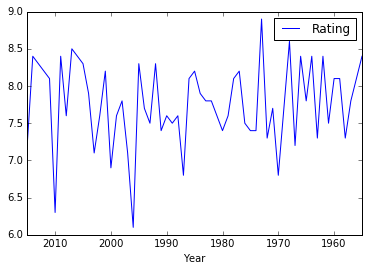

In [233]:
df.plot(x=df.Year,y=['Rating']);

## Movies with Lowest Ratings

In [234]:
df1=df.sort_values('Rating',ascending=[True]).head(5)
df1.index = np.arange(1, 6)
df1

,Year,Movie Name,Rating,Votes,Genre,RunTime,Director
1,1996,Raja Hindustani,6.1,4803,Drama,165,Dharmesh Darshan
2,2010,Dabangg,6.3,19777,Family,126,Abhinav Singh Kashyap
3,1987,Ram Teri Ganga Maili,6.8,686,Family,178,Raj Kapoor
4,1970,Brahmachari,6.8,239,Drama,157,Bhappi Sonie
5,2000,Kaho Naa... Pyaar Hai,6.9,7877,Drama,172,Rakesh Roshan


## Movies with Maximum Run time

## Top 10 movies with maximum Run time

In [235]:
#Movies with maximum Run Time
df1=df.sort_values(['RunTime'],ascending=[False]).head(10)
df1.index = np.arange(1, 11)
df1

,Year,Movie Name,Rating,Votes,Genre,RunTime,Director
1,2001,Lagaan: Once Upon a Time in India,8.2,68900,Romance,224,Ashutosh Gowariker
2,2008,Jodhaa Akbar,7.6,17911,Drama,213,Ashutosh Gowariker
3,1994,Hum Aapke Hain Koun...!,7.7,10953,Drama,206,Sooraj R. Barjatya
4,1962,Mughal-E-Azam,8.4,3871,Crime,197,K. Asif
5,1989,Maine Pyar Kiya,7.5,5802,Drama,192,Sooraj R. Barjatya
6,2004,Veer-Zaara,7.9,33493,Mystery,192,Yash Chopra
7,1995,Dilwale Dulhania Le Jayenge,8.3,42076,Musical,189,Aditya Chopra
8,1999,Straight from the Heart,7.6,9797,Romance,188,Sanjay Leela Bhansali
9,1991,Lamhe,7.4,1929,Musical,187,Yash Chopra
10,2013,Bhaag Milkha Bhaag,8.3,39731,Drama,186,Rakeysh Omprakash Mehra


## Best Movie Run time

## Let's plot a graph to see the movie run time trend from 1955 thru 2015

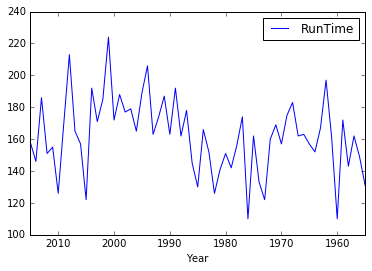

In [236]:
df.plot(x=df.Year,y=['RunTime']);

## Mean of the Movie Run Time

In [237]:
df['RunTime'].mean()

162.2295081967213

# Best Movie Ratings

## Perform some analysis on the ratings of all the Best won movies

* No. of Movies Greater than IMDB 7 ratings

In [238]:
df[(df['Rating']>=7)]['Rating'].count()

56

## Movie Ratings Visualization using Bar Graph

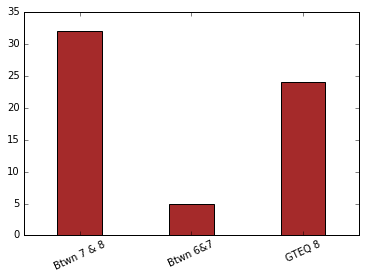

In [240]:
Rating_Histdic = defaultdict(dict)

Rating_Histdic['Btwn 6&7'] = df[(df['Rating']>=6)&(df['Rating']<7)]['Rating'].count()
Rating_Histdic['GTEQ 8'] = df[(df['Rating']>=8)]['Rating'].count()
Rating_Histdic['Btwn 7 & 8'] = df[(df['Rating']>=7)&(df['Rating']<8)]['Rating'].count()


plt.bar(range(len(Rating_Histdic)), Rating_Histdic.values(), align='center',color='brown',width=0.4)
plt.xticks(range(len(Rating_Histdic)), Rating_Histdic.keys(), rotation=25);

## Percentage distribution of the Ratings in a Pie-Chart

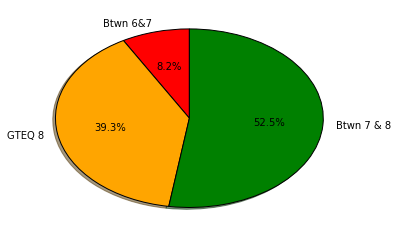

In [241]:
Rating_Hist = []
import numpy as np
    
Rating_Hist.append(Rating_Histdic['Btwn 6&7'])
Rating_Hist.append(Rating_Histdic['GTEQ 8'])
Rating_Hist.append(Rating_Histdic['Btwn 7 & 8'])

labels = ['Btwn 6&7', 'GTEQ 8', 'Btwn 7 & 8']
colors = ['red', 'orange', 'green']

plt.pie(Rating_Hist,labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90);

## Best Picture by Genre

## Let's analyze the Genre for the best won movies

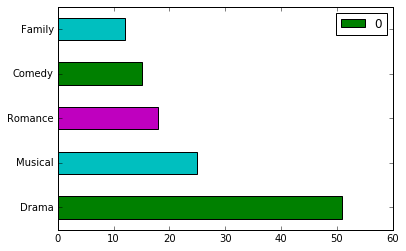

In [25]:
Category=Counter(datatbl['data']['Genre'])
df1 = pd.DataFrame.from_dict(Category,orient='index')
df1 = df1.sort_values([0],ascending=[False]).head(5)
df1.plot(kind='barh',color=['g','c','m']);

## Directors whose movie won more than once for Best Film

## Movies for which they won best film award

In [270]:
df['freq']= df.groupby('Director')['Director'].transform('count')
df2=df[df['freq']>1]
del df2['freq']

In [276]:
df2.groupby(['Director','Year', 'Movie Name',
             'Rating', 'Genre','Votes','RunTime']).count()[0:8]

Empty DataFrame
Columns: []
Index: [(Ashutosh Gowariker, 2001, Lagaan: Once Upon a Time in India, 8.2, Romance, 68900, 224.0), (Ashutosh Gowariker, 2008, Jodhaa Akbar, 7.6, Drama, 17911, 213.0), (Bimal Roy, 1955, Do Bigha Zamin, 8.4, Drama, 1104, 131.0), (Bimal Roy, 1960, Madhumati, 8.1, Musical, 793, 110.0), (Bimal Roy, 1961, Sujata, 7.5, Drama, 191, 161.0), (Bimal Roy, 1965, Bandini, 7.8, Drama, 546, 157.0), (Hrishikesh Mukherjee, 1973, Anand, 8.9, Drama, 10732, 122.0), (Hrishikesh Mukherjee, 1982, Khubsoorat, 7.8, Musical, 939, 126.0)]

# Conclusion : 
  
* Movies with Ratings greater than 7  
* Run time more than 2hrs 
* Category Drama & Musical are most likely to be selcted for Best Picture